In [497]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
plt.style.use('ggplot') 
%matplotlib inline

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis. The query was exported from Porticoto the file ADMISSIONS_ICUSTAY_SEPSIS.csv. The data was read into a pandas dataframe lab_events 


In [492]:
data = pd.DataFrame.from_csv('SEPSIS_LABEVENTS_FIRST_py.csv')
data.head()

,hadm_id,icustay_id,mort_icu,mort_hosp,diagnosis,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
subject_id,,,,,,,,,,,,,,,,,,,,,
21,111970,216859,1,1,SEPSIS,19.0,2.1,23.0,0.3,4.2,...,1.5,4.4,275.0,3.8,31.7,1.7,18.1,137.0,49.0,30.5
94,183686,229012,0,0,SEPSIS,13.0,NaN,23.0,1.4,0.6,...,1.4,2.1,162.0,2.5,31.0,1.0,12.0,132.0,8.0,6.0
157,107880,264885,0,0,SEPSIS,22.0,NaN,20.0,0.6,0.8,...,2.3,4.4,255.0,4.9,30.1,1.2,13.3,135.0,15.0,52.0
166,128219,271863,1,1,SEPSIS,19.0,NaN,24.0,NaN,0.8,...,NaN,NaN,341.0,3.7,22.8,1.2,13.5,142.0,20.0,16.5
188,191517,278679,0,0,SEPSIS,14.0,2.9,17.0,1.8,2.4,...,1.0,3.3,266.0,5.0,32.7,1.2,13.7,133.0,31.0,16.7


## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [493]:
data['subject_id'] = data.index
data.set_index(np.arange(data.shape[0]), inplace = True)
cols = list(data.columns.values)
cols = cols[-1:] + cols[:-1]
data = data[cols]
data.head()

,subject_id,hadm_id,icustay_id,mort_icu,mort_hosp,diagnosis,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,21,111970,216859,1,1,SEPSIS,19.0,2.1,23.0,0.3,...,1.5,4.4,275.0,3.8,31.7,1.7,18.1,137.0,49.0,30.5
1,94,183686,229012,0,0,SEPSIS,13.0,NaN,23.0,1.4,...,1.4,2.1,162.0,2.5,31.0,1.0,12.0,132.0,8.0,6.0
2,157,107880,264885,0,0,SEPSIS,22.0,NaN,20.0,0.6,...,2.3,4.4,255.0,4.9,30.1,1.2,13.3,135.0,15.0,52.0
3,166,128219,271863,1,1,SEPSIS,19.0,NaN,24.0,NaN,...,NaN,NaN,341.0,3.7,22.8,1.2,13.5,142.0,20.0,16.5
4,188,191517,278679,0,0,SEPSIS,14.0,2.9,17.0,1.8,...,1.0,3.3,266.0,5.0,32.7,1.2,13.7,133.0,31.0,16.7


In [494]:
# dropping diagnosis column as all patients are septic
data.drop('diagnosis', axis=1, inplace = True)
data.head()

,subject_id,hadm_id,icustay_id,mort_icu,mort_hosp,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,21,111970,216859,1,1,19.0,2.1,23.0,0.3,4.2,...,1.5,4.4,275.0,3.8,31.7,1.7,18.1,137.0,49.0,30.5
1,94,183686,229012,0,0,13.0,NaN,23.0,1.4,0.6,...,1.4,2.1,162.0,2.5,31.0,1.0,12.0,132.0,8.0,6.0
2,157,107880,264885,0,0,22.0,NaN,20.0,0.6,0.8,...,2.3,4.4,255.0,4.9,30.1,1.2,13.3,135.0,15.0,52.0
3,166,128219,271863,1,1,19.0,NaN,24.0,NaN,0.8,...,NaN,NaN,341.0,3.7,22.8,1.2,13.5,142.0,20.0,16.5
4,188,191517,278679,0,0,14.0,2.9,17.0,1.8,2.4,...,1.0,3.3,266.0,5.0,32.7,1.2,13.7,133.0,31.0,16.7


In [174]:
# create a list of columns that only includes lab measures for use in analysis
lab_measures = list(data.columns[5:])
print lab_measures

['aniongap_1st', 'albumin_1st', 'bicarbonate_1st', 'bilirubin_1st', 'creatinine_1st', 'chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'lactate_1st', 'magnesium_1st', 'phosphate_1st', 'platelet_1st', 'potassium_1st', 'ptt_1st', 'inr_1st', 'pt_1st', 'sodium_1st', 'bun_1st', 'wbc_1st']


In [175]:
lab_measures.sort()
print lab_measures

['albumin_1st', 'aniongap_1st', 'bicarbonate_1st', 'bilirubin_1st', 'bun_1st', 'chloride_1st', 'creatinine_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'inr_1st', 'lactate_1st', 'magnesium_1st', 'phosphate_1st', 'platelet_1st', 'potassium_1st', 'pt_1st', 'ptt_1st', 'sodium_1st', 'wbc_1st']


In [176]:
# a dictionary is created which contains normal ranges for lab measurements 
lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }



In [177]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
# a list is created containing units of measure for the lab measurements
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

# currently using lab_measures and lab_units to create the dict. 
# could be done more succinctly using the dictionary described above
labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict


{'wbc_1st': '', 'bicarbonate_1st': 'mEq/L', 'phosphate_1st': 'mg/dL', 'hematocrit_1st': '%', 'chloride_1st': 'mEq/L', 'lactate_1st': 'mmol/L', 'potassium_1st': 'mEq/L', 'glucose_1st': 'mg/dL', 'creatinine_1st': 'mg/dL', 'magnesium_1st': 'mmol/L', 'aniongap_1st': 'mEq/L', 'pt_1st': '', 'hemoglobin_1st': 'g/dL', 'ptt_1st': 'sec', 'albumin_1st': 'g/dL', 'bun_1st': '', 'inr_1st': '', 'bilirubin_1st': 'mg/dL', 'sodium_1st': 'mmol/L', 'platelet_1st': 'K/uL'}


In [496]:
l = lab_measures[0]
print "number of non_survivors              = {}".format(data[data.mort_hosp==1].count())
print "numver of survivors                  = {}".format(data[data.mort_hosp==0].count())

number of non_survivors              = subject_id         307
hadm_id            307
icustay_id         307
mort_icu           307
mort_hosp          307
aniongap_1st       302
albumin_1st        208
bicarbonate_1st    302
bilirubin_1st      248
creatinine_1st     303
chloride_1st       305
glucose_1st        305
hematocrit_1st     302
hemoglobin_1st     302
lactate_1st        280
magnesium_1st      293
phosphate_1st      293
platelet_1st       301
potassium_1st      305
ptt_1st            288
inr_1st            290
pt_1st             290
sodium_1st         305
bun_1st            303
wbc_1st            300
dtype: int64
numver of survivors                  = subject_id         983
hadm_id            983
icustay_id         983
mort_icu           983
mort_hosp          983
aniongap_1st       973
albumin_1st        616
bicarbonate_1st    973
bilirubin_1st      752
creatinine_1st     974
chloride_1st       974
glucose_1st        974
hematocrit_1st     974
hemoglobin_1st     974
lactate_1st 

In [179]:
# code to generate descriptive stats on each lab measurement. 
# the example here is albumin. will be used below for plotting data

l = lab_measures[0]
ded = 0
print "number of non_survivors              = {}".format(data[l][data.mort_icu==1].dropna().count())
print "numver of survivors                  = {}".format(data[l][data.mort_icu==0].dropna().count())
print "median value of {} for non_survivors = {}".format(l,data[l][data.mort_icu==1].dropna().median())
print "median value of {} for survivors     = {}".format(l,data[l][data.mort_icu==0].dropna().median())
print "variance of {} for non_survivors     = {}".format(l,data[l][data.mort_icu==1].dropna().var())
print "variance of {} for survivors         = {}".format(l,data[l][data.mort_icu==0].dropna().var())
print "skewness of {} for non_survivors     = {}".format(l,data[l][data.mort_icu==1].dropna().skew())
print "skewness of {} for survivors         = {}".format(l,data[l][data.mort_icu==0].dropna().skew())


number of non_survivors              = 137
numver of survivors                  = 687
median value of albumin_1st for non_survivors = 2.4
median value of albumin_1st for survivors     = 2.9
variance of albumin_1st for non_survivors     = 0.365112709317
variance of albumin_1st for survivors         = 0.465424438022
skewness of albumin_1st for non_survivors     = 0.0800886777727
skewness of albumin_1st for survivors         = 0.287128916203


In [11]:
# the kolmogorov smirnov test is a measure the probability that samples
# have come from the same distribution. The results including a very small p-value  
# indicate that albumin measures from survivors and non survivors do not come from similar distributions
ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

print "kolmogorov smirnov test shows {}  with p-value of {}".format(ks_stat, p_val)


kolmogorov smirnov test shows 0.273855438328  with p-value of 4.76343027427e-08


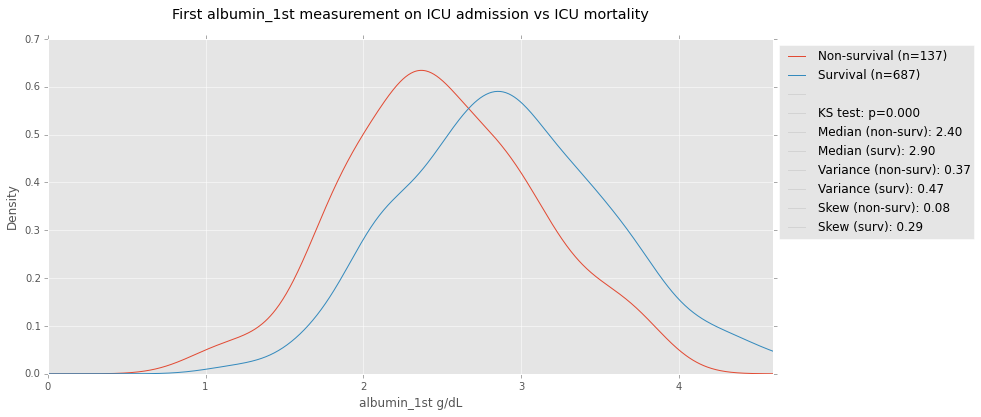

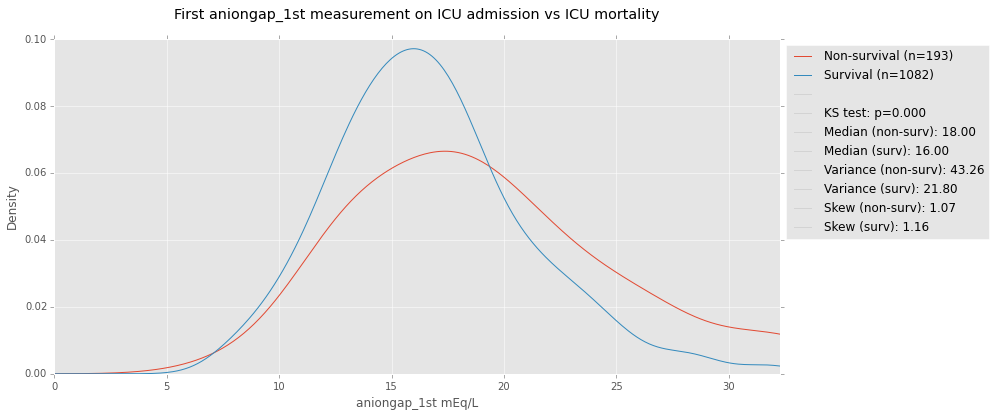

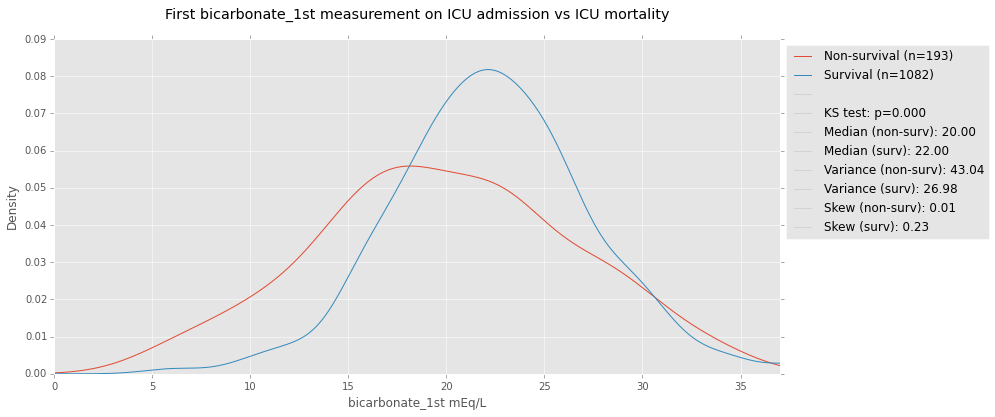

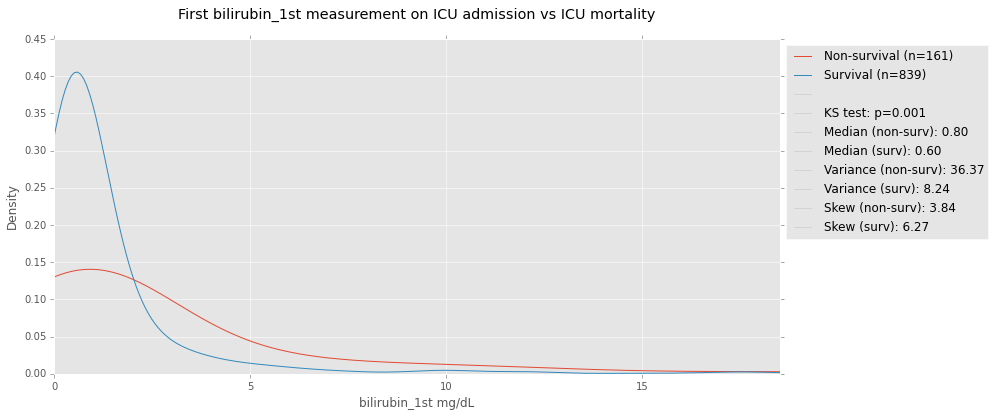

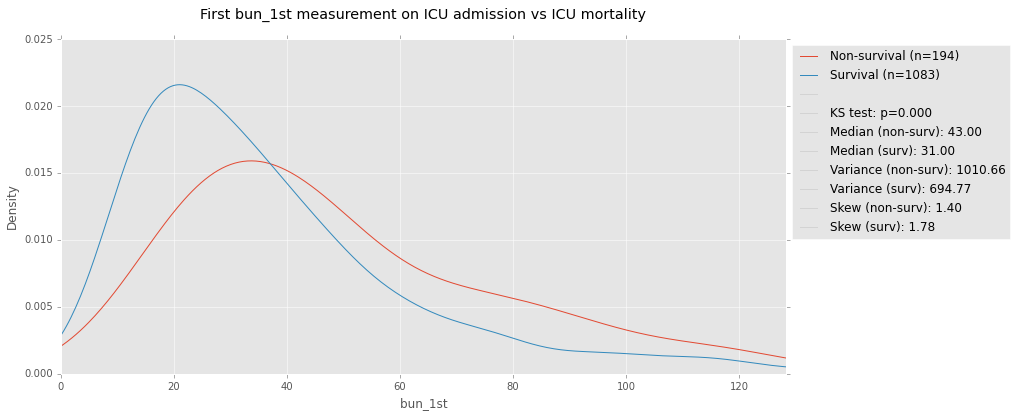

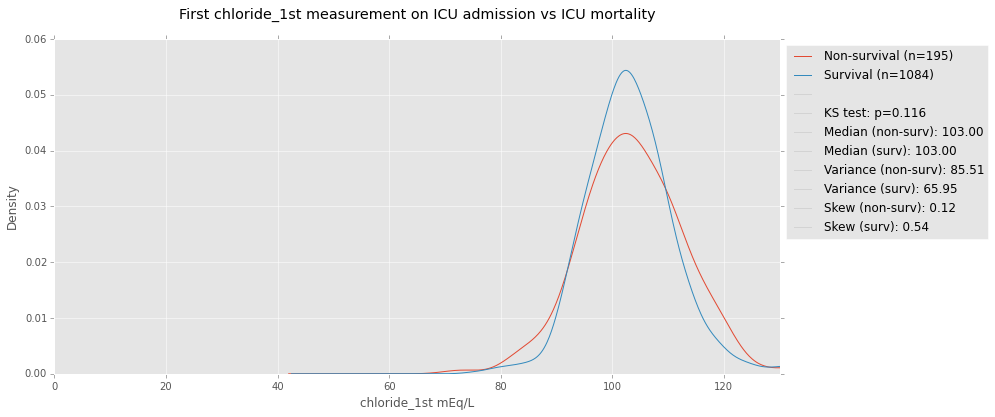

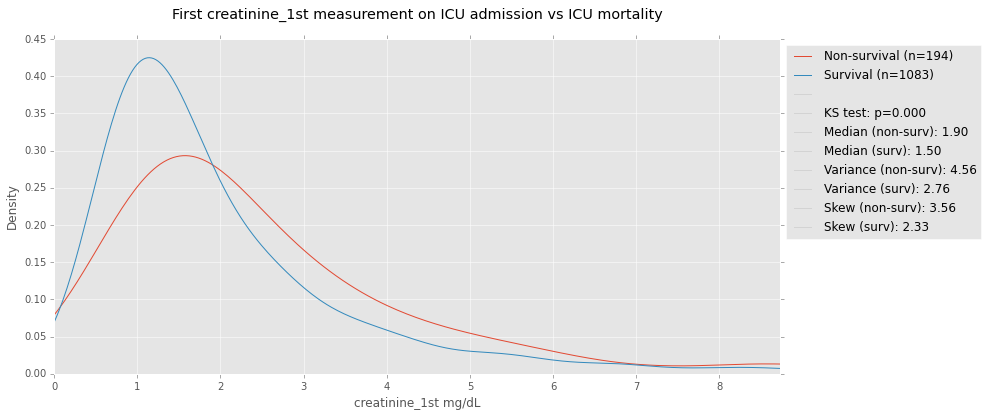

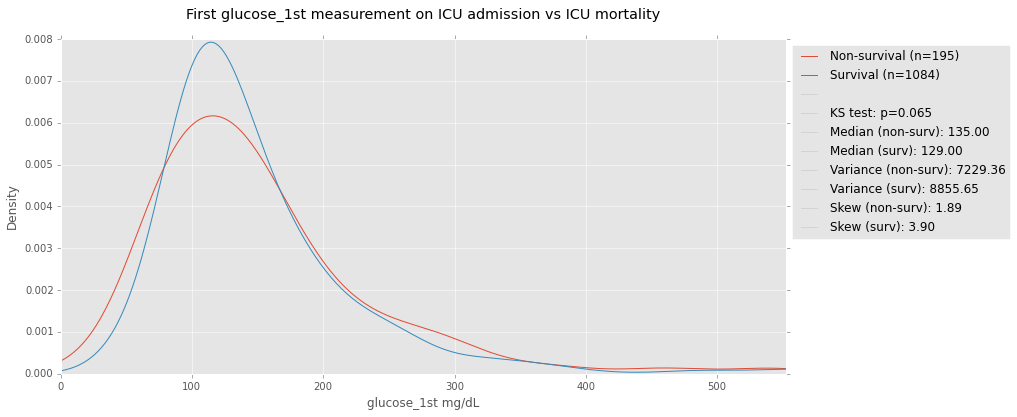

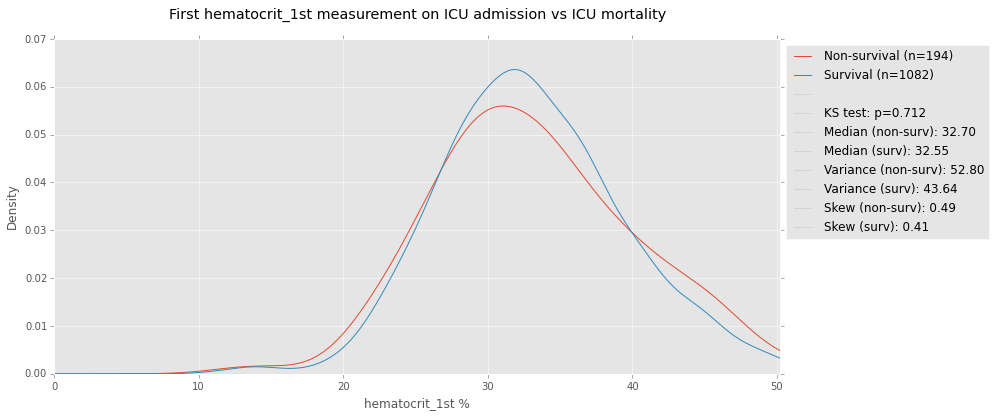

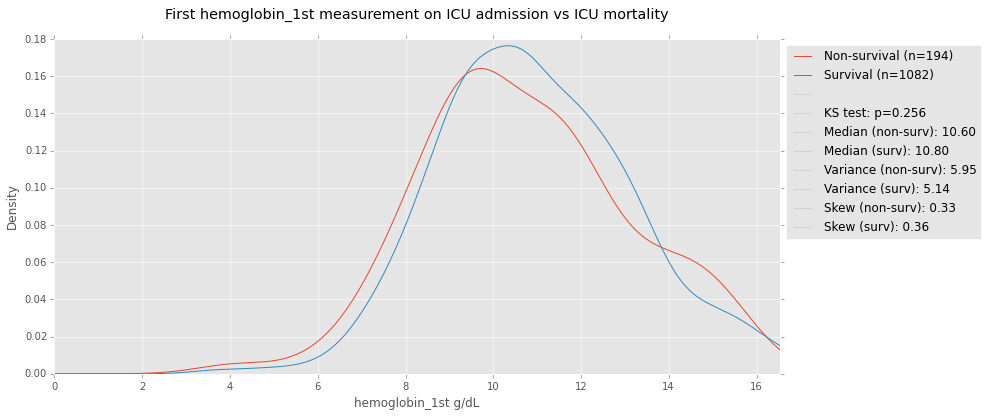

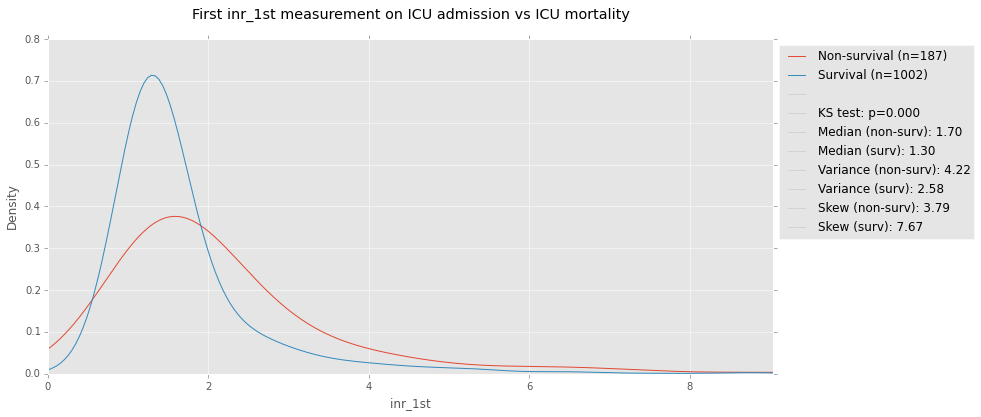

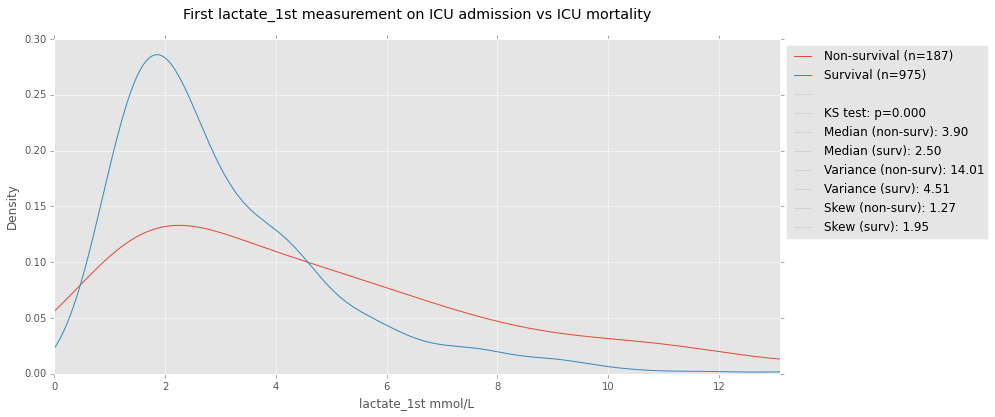

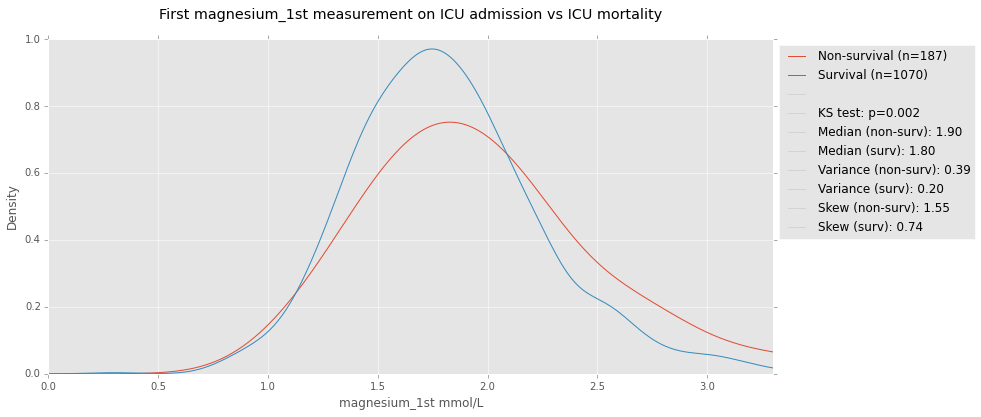

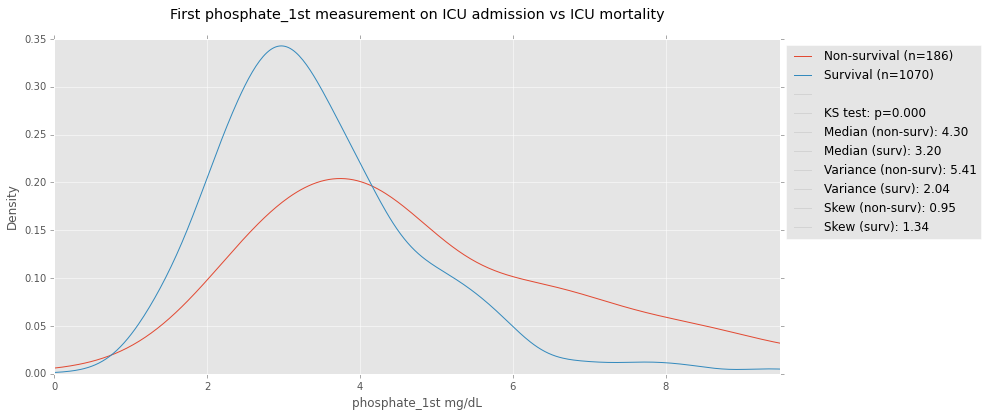

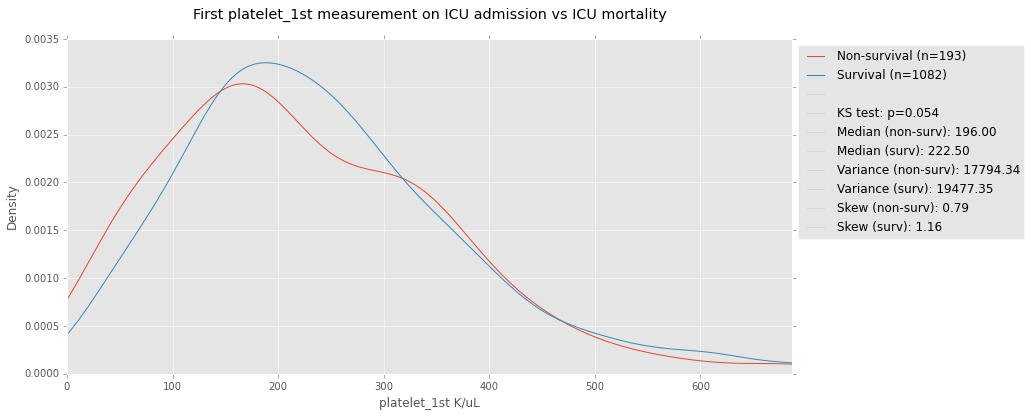

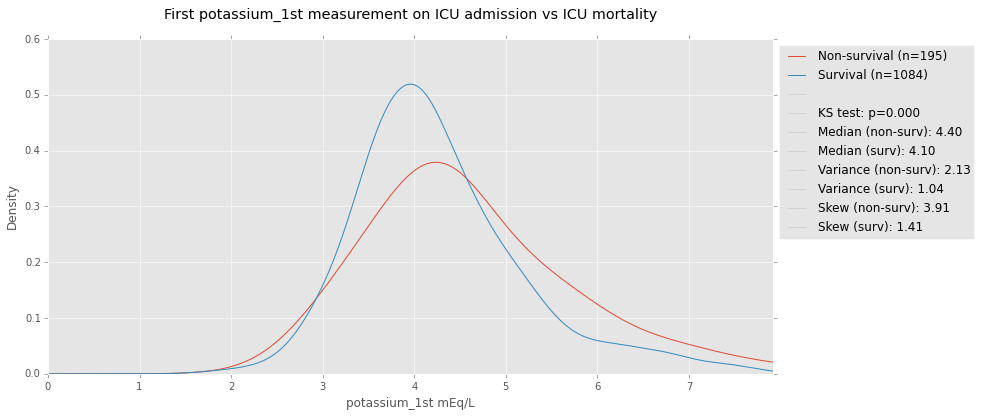

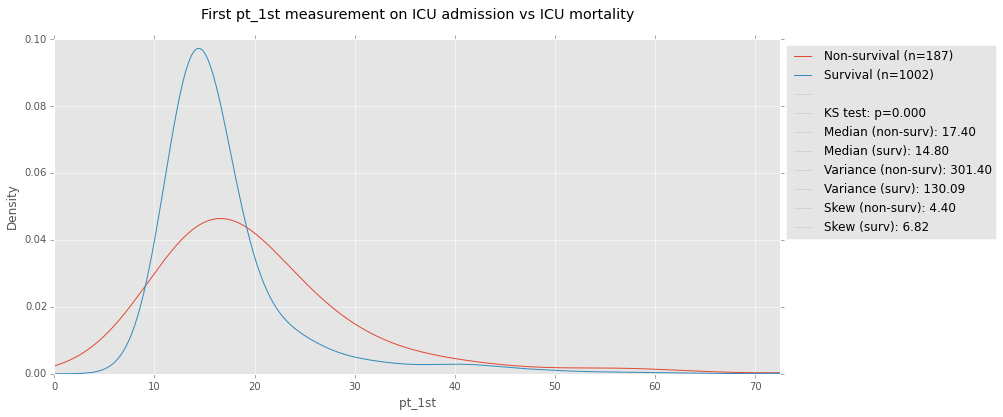

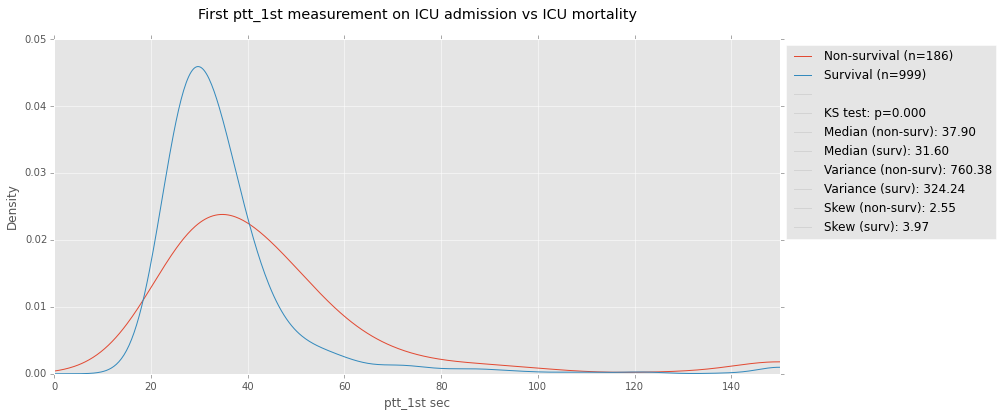

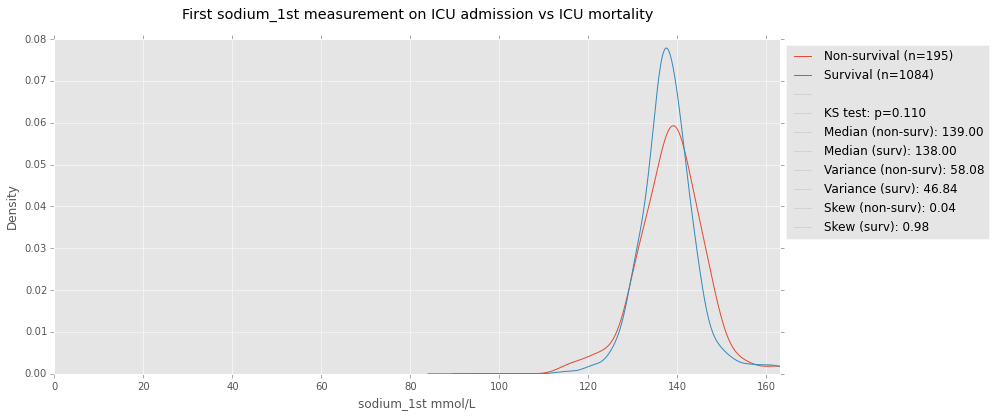

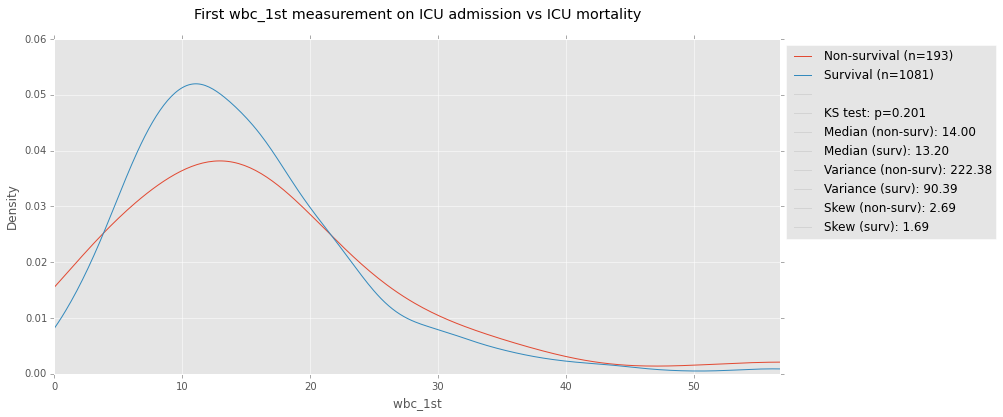

In [180]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = data[l][data.mort_icu==1].dropna().count()
    n_surv = data[l][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l][data.mort_icu==1].dropna().median()
    med_surv = data[l][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l][data.mort_icu==1].dropna().var()
    var_surv = data[l][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l][data.mort_icu==1].dropna().skew()
    skew_surv = data[l][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

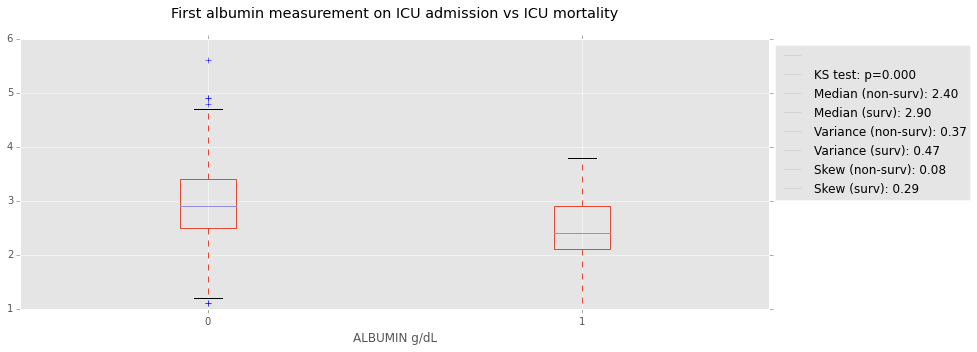

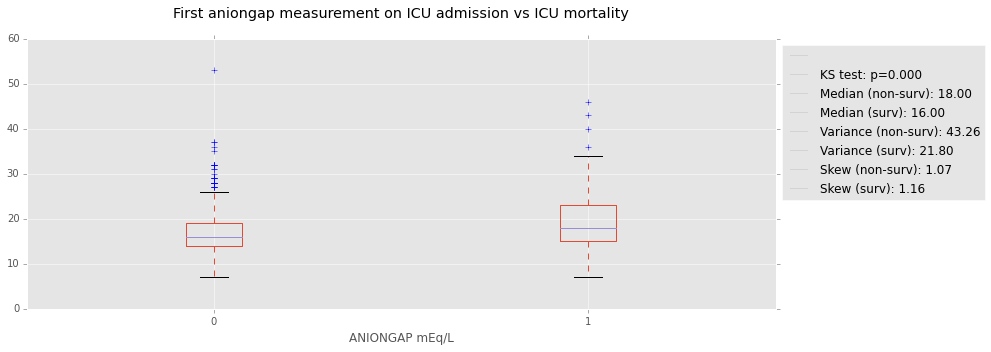

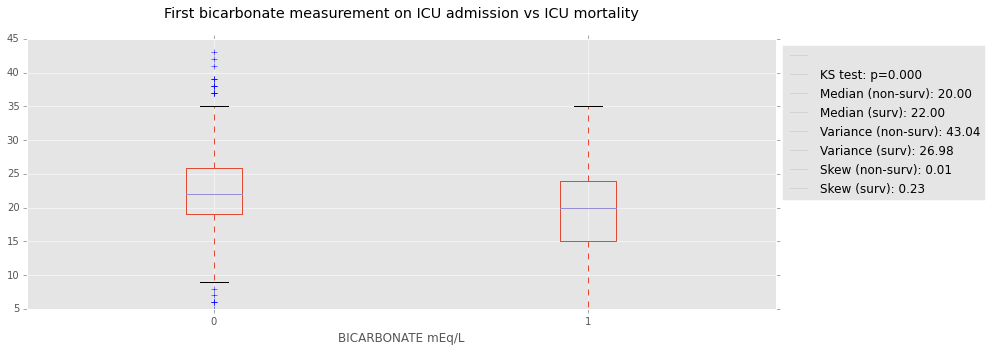

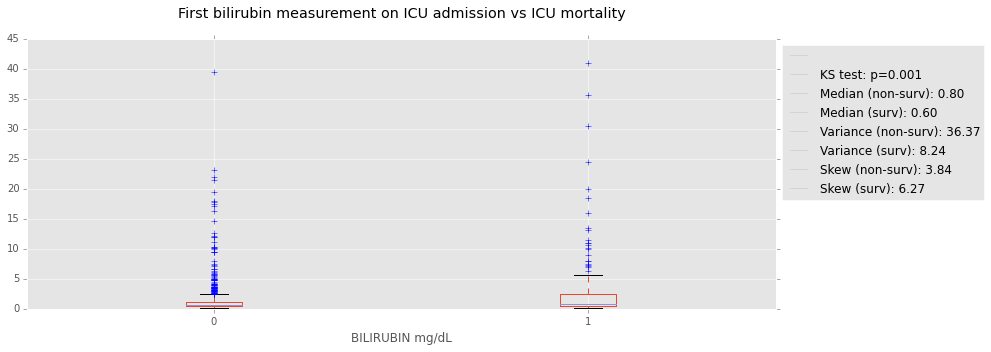

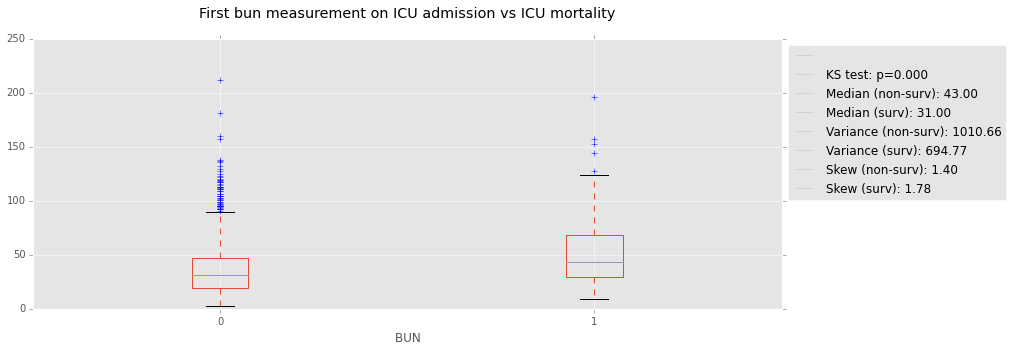

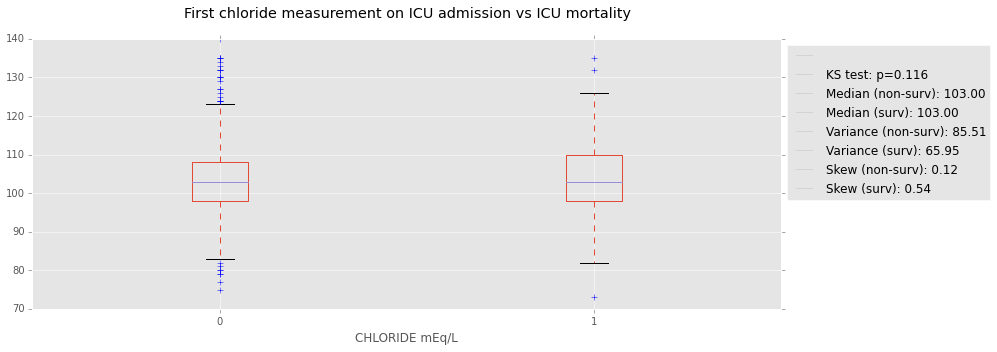

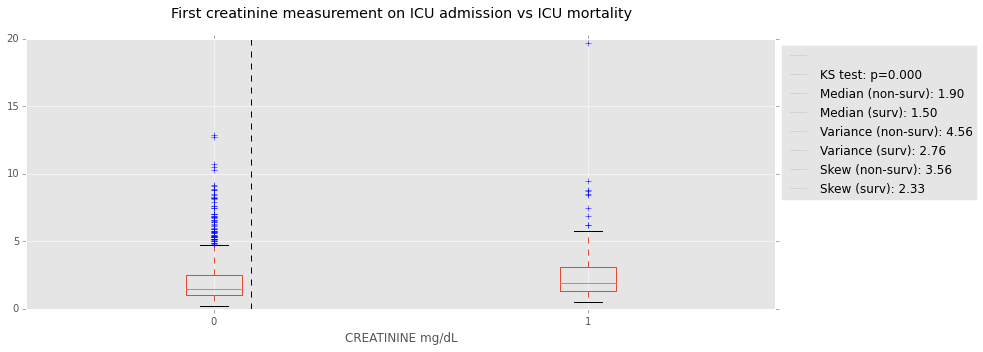

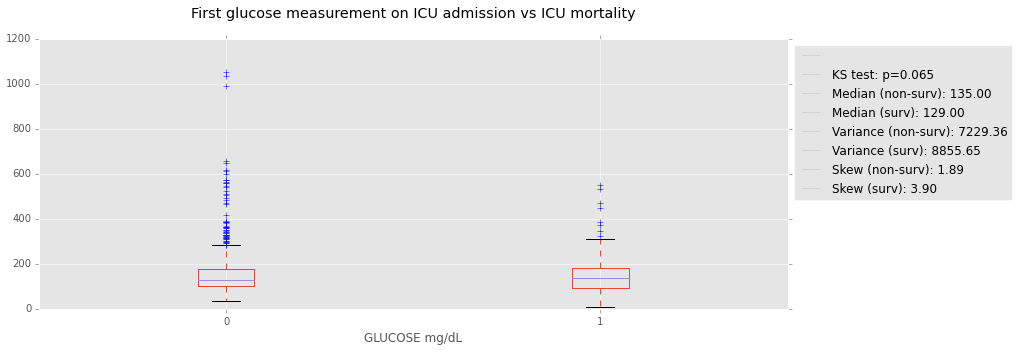

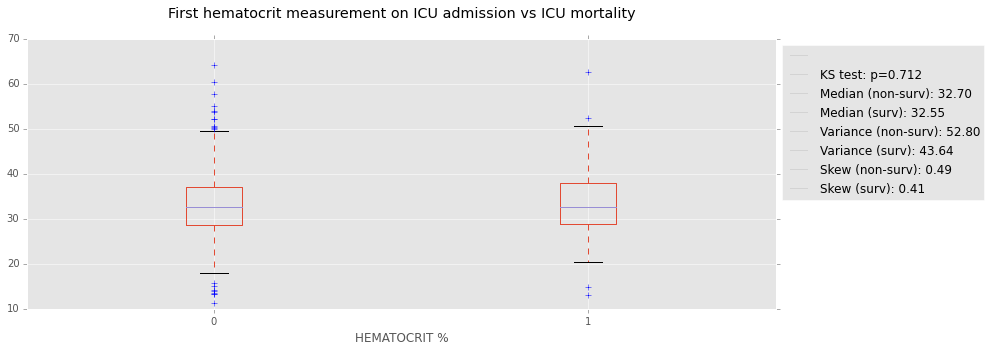

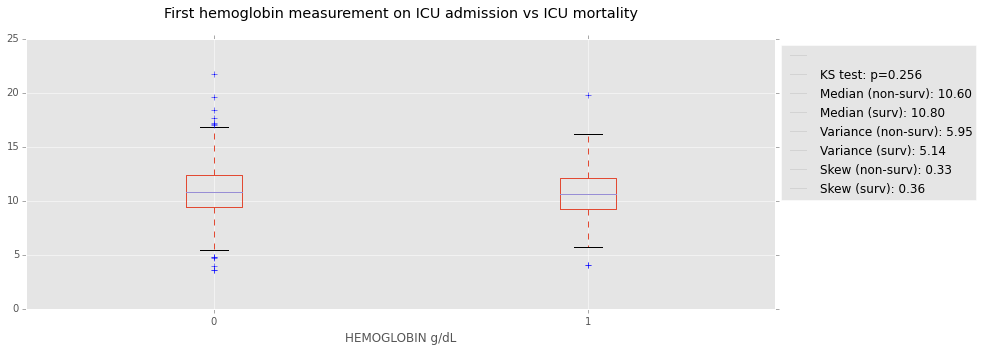

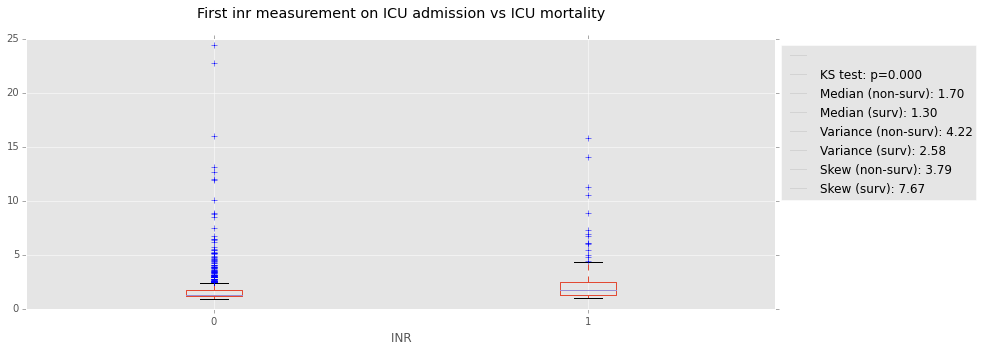

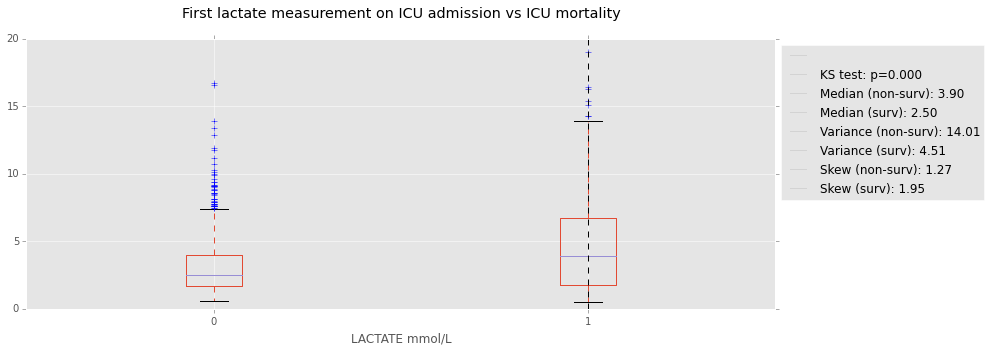

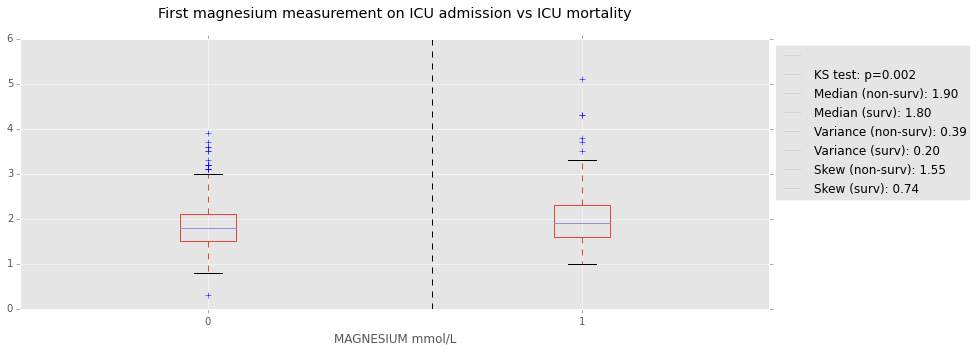

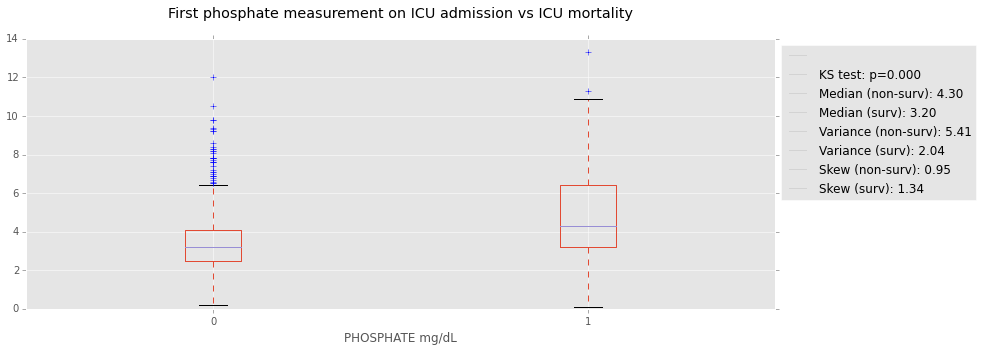

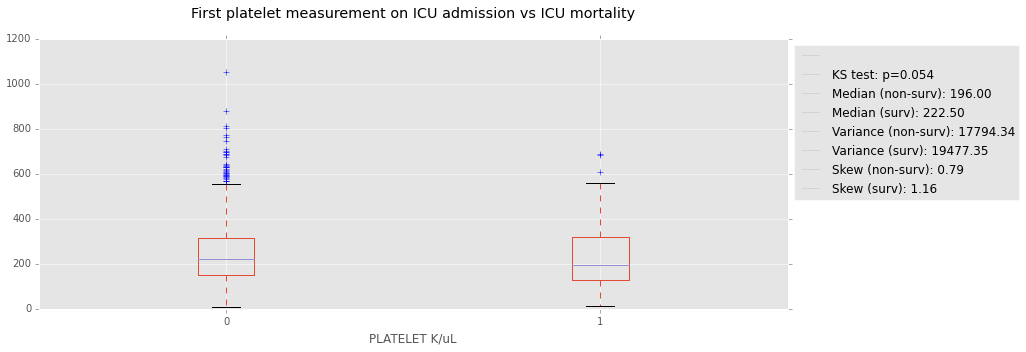

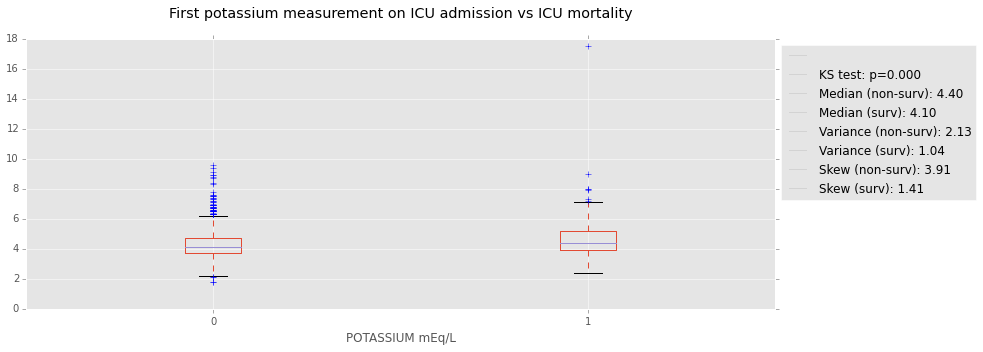

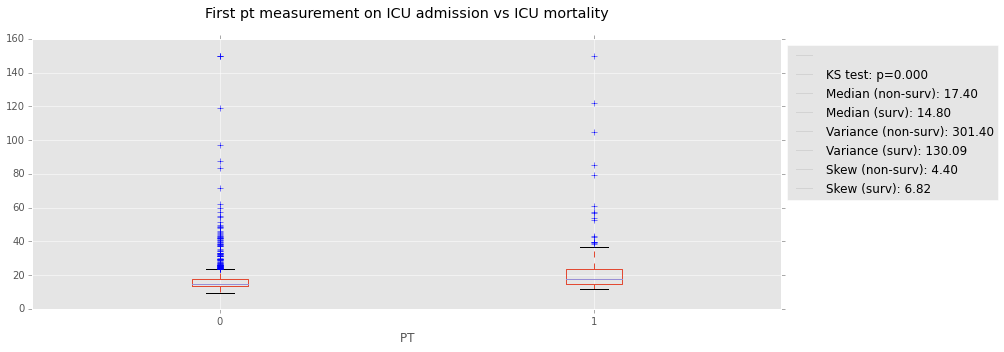

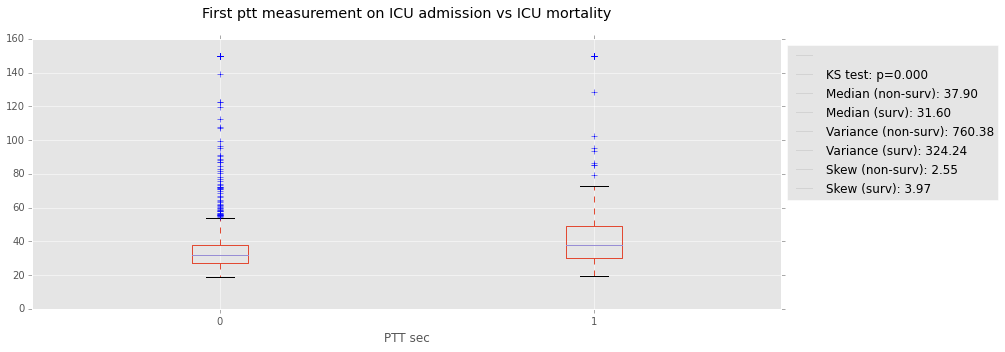

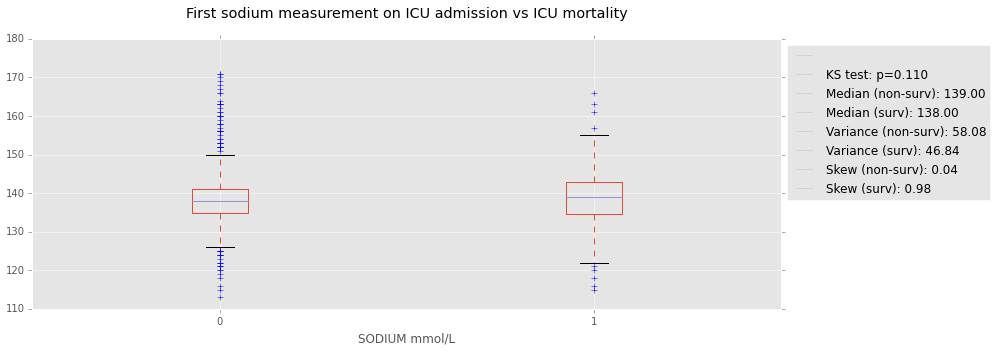

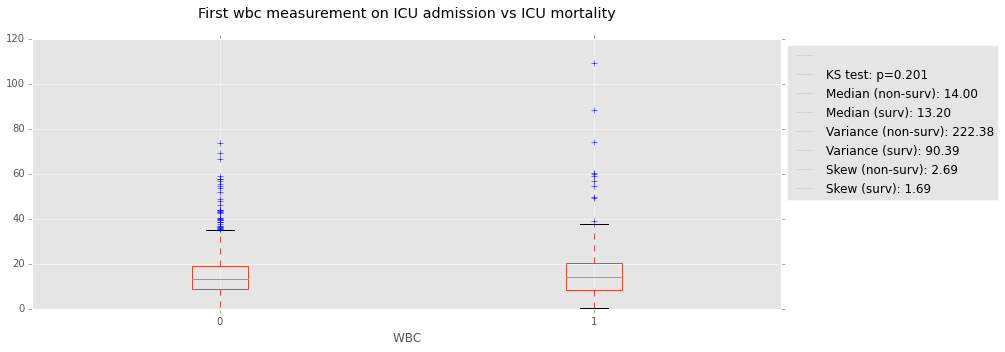

In [181]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    #fig, ax1 = plt.subplots(figsize=(13, 6))
    #fig.canvas.set_window_title('A Boxplot Example')
    #plt.subplots(figsize=(13,6))
    #box_data = data[['mort_icu', l.lower()+'_1st']].dropna()
    data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
   #data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #    label='Non-survival (n={})'.format(n_nonsurv))
    plt.suptitle("")
    '''
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.box(
        label='Survival (n={})'.format(n_surv))
    '''
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    
   # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data[l.lower()+'_1st'].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    

In [314]:
# creating data2 dataframe containing just icu mortality and lab results info. 
cols = list(data.columns[3:])
cols.remove('mort_hosp')
data2 = data[cols].dropna().copy()
data2.set_index(np.arange(data2.shape[0]), inplace = True)
data2.head()
#data2.dropna(inplace = True)
# I believe this can be done more efficiently with sklearn.preprocessing.scale
data2_norm = data2.copy()
for feature_name in data2.columns:
    max_value = data2[feature_name].max()
    min_value = data2[feature_name].min()
    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)

data2_norm.head()

,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,chloride_1st,glucose_1st,hematocrit_1st,hemoglobin_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,1.0,0.260870,0.239130,0.473684,0.005618,0.314961,0.400000,0.187926,0.346591,0.303867,...,0.250000,0.361345,0.254075,0.127389,0.098323,0.034043,0.054480,0.452830,0.238342,0.278899
1,0.0,0.152174,0.413043,0.315789,0.047753,0.173228,0.400000,0.057449,0.450758,0.480663,...,0.145833,0.268908,0.245446,0.203822,0.105945,0.012766,0.022939,0.377358,0.145078,0.152294
2,0.0,0.326087,0.347826,0.657895,0.005618,0.582677,0.266667,0.117819,0.416667,0.419890,...,0.354167,0.243697,0.148610,0.210191,0.046494,0.017021,0.026523,0.471698,0.326425,0.119266
3,0.0,0.217391,0.413043,0.394737,0.002809,0.133858,0.950000,0.218111,0.382576,0.359116,...,0.416667,0.210084,0.094919,0.082803,0.083841,0.021277,0.038710,1.000000,0.383420,0.044954
4,0.0,0.239130,0.586957,0.578947,0.019663,0.102362,0.466667,0.172347,0.640152,0.668508,...,0.291667,0.184874,0.198466,0.222930,0.074695,0.012766,0.020789,0.566038,0.072539,0.279817


In [324]:
data2_norm['aniongap_1st'].add(1).describe()
box_cox_aniongap = scats.boxcox(data2_norm['aniongap_1st'].add(1))

In [396]:
# create dict from which we'll build skew measures dataframe
skew_dict2 = {data2_norm.columns[1]:
              {
             'raw_skew': scats.skew(data2_norm[data2_norm.columns[1]]), 
             'sqrt_skew': scats.skew(np.sqrt(data2_norm[data2_norm.columns[1]])), 
             'log_skew': scats.skew(np.log(data2_norm[data2_norm.columns[1]].add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data2_norm[data2_norm.columns[1]].add(1))[0])
             }
             }

print skew_dict2
skew_df = pd.DataFrame.from_dict(skew_dict2, orient = 'index')  
skew_df

{'aniongap_1st': {'sqrt_skew': 0.17908879025962815, 'raw_skew': 1.3916411570405636, 'boxcox_skew': -0.014478833553559833, 'log_skew': 0.9008946469405678}}


,sqrt_skew,raw_skew,boxcox_skew,log_skew
aniongap_1st,0.179089,1.391641,-0.014479,0.900895


In [398]:
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]


In [399]:
skew_df

,raw_skew,sqrt_skew,log_skew,boxcox_skew
aniongap_1st,1.391641,0.179089,0.900895,-0.014479


In [400]:
              
for col in data2_norm.columns[2:]:
    raw_skew = scats.skew(data2_norm[col])
    
    sqrt_skew = scats.skew(np.sqrt(data2_norm[col]))
    log_skew = scats.skew(np.log(data2_norm[col].add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data2_norm[col].add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df

,raw_skew,sqrt_skew,log_skew,boxcox_skew
aniongap_1st,1.391641,0.179089,0.900895,-0.014479
albumin_1st,0.309465,-0.532702,-0.019723,0.000088
bicarbonate_1st,0.125783,-0.960734,-0.282071,0.014463
bilirubin_1st,5.321222,2.568328,4.406003,0.909886
creatinine_1st,2.226479,0.991802,1.761148,0.191877
chloride_1st,0.472296,-0.518275,0.058611,-0.004712
glucose_1st,3.471611,1.663329,2.651977,0.084497
hematocrit_1st,0.284947,-0.706321,-0.090050,0.005168
hemoglobin_1st,0.236609,-0.814194,-0.108915,0.004531
lactate_1st,1.923699,0.745540,1.472686,0.206467


In [409]:
skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'

## The figure below shows the skewness values for each lab measurement for normalized data that has been transformed by taking the log, the square root and using the box-cox function. It can be seen that the box-cox function performed better than other transforms in reducing skewness. 


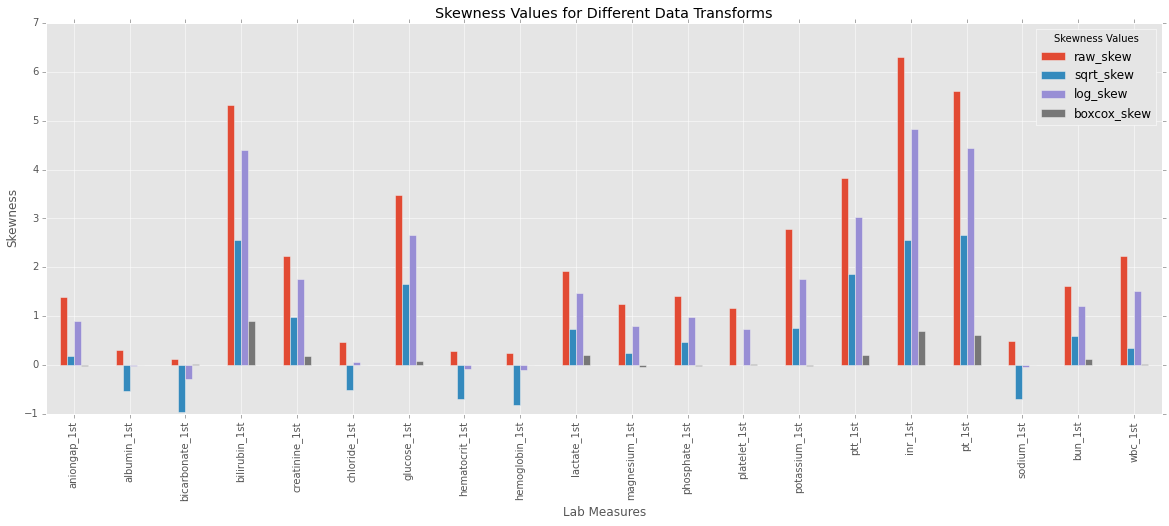

In [411]:
ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [413]:
data2_norm.columns

Index([u'mort_icu', u'aniongap_1st', u'albumin_1st', u'bicarbonate_1st',
       u'bilirubin_1st', u'creatinine_1st', u'chloride_1st', u'glucose_1st',
       u'hematocrit_1st', u'hemoglobin_1st', u'lactate_1st', u'magnesium_1st',
       u'phosphate_1st', u'platelet_1st', u'potassium_1st', u'ptt_1st',
       u'inr_1st', u'pt_1st', u'sodium_1st', u'bun_1st', u'wbc_1st'],
      dtype='object')

In [415]:
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_norm_data = data2_norm.copy()
for feature_name in data2.columns[1:]:
    boxcox_norm_data[feature_name] = scats.boxcox(data2_norm[feature_name].add(1))[0]

boxcox_norm_data.head()

,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,chloride_1st,glucose_1st,hematocrit_1st,hemoglobin_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,1.0,0.173122,0.215796,0.447806,0.005264,0.133796,0.328092,0.093346,0.309008,0.277090,...,0.172416,0.208851,0.176570,0.088949,0.068668,0.023027,0.034013,0.378950,0.143095,0.147217
1,0.0,0.118069,0.349360,0.303665,0.028906,0.102437,0.328092,0.045022,0.390074,0.418574,...,0.115979,0.175342,0.172431,0.118493,0.072159,0.010940,0.018579,0.324156,0.104298,0.104110
2,0.0,0.198636,0.301184,0.610716,0.005264,0.155080,0.232232,0.073646,0.364037,0.371294,...,0.214818,0.164544,0.118684,0.120456,0.038899,0.013884,0.020821,0.392237,0.168361,0.087908
3,0.0,0.153243,0.349360,0.376296,0.002719,0.088008,0.635353,0.099056,0.337527,0.322626,...,0.235339,0.148818,0.081866,0.065015,0.061474,0.016537,0.027414,0.712025,0.180700,0.039807
4,0.0,0.163501,0.468281,0.541540,0.015772,0.073639,0.372159,0.089847,0.526931,0.556896,...,0.190784,0.135913,0.148140,0.124193,0.056517,0.010940,0.017160,0.456404,0.060984,0.147448


## Performing PCA on normalized data in an effort to reduce dimensionality. 

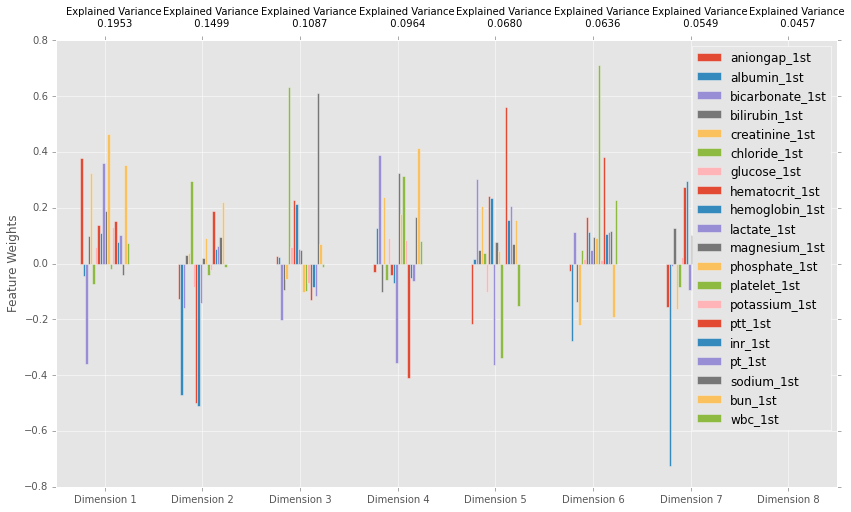

In [232]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 8).fit(data2_norm[data2_norm.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(data2_norm[data2_norm.columns[1:]], pca)

## Performing PCA on box-cox transformed data in an effort to reduce dimensionality

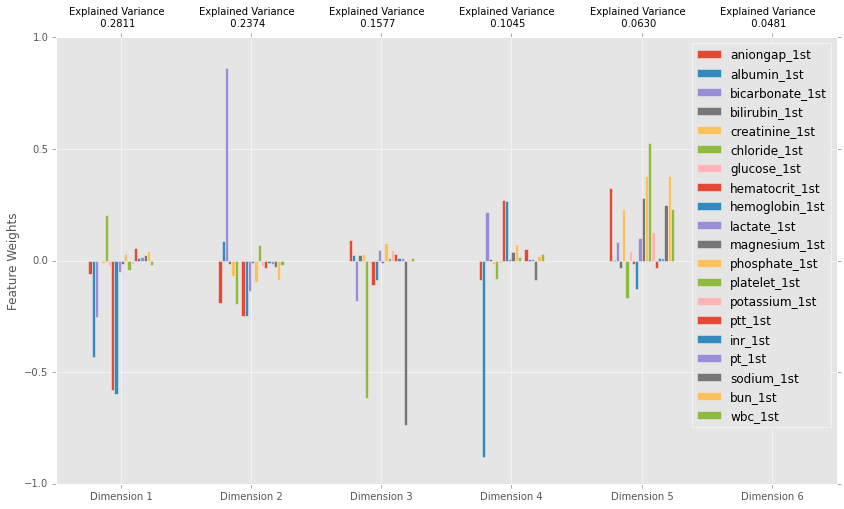

In [417]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca_boxcox = PCA(n_components = 6).fit(boxcox_norm_data[boxcox_norm_data.columns[1:]])

# Generate PCA results plot
pca_boxcox_results = vs.pca_results(boxcox_norm_data[boxcox_norm_data.columns[1:]], pca_boxcox)

## Code to identify outliers in normalized data

In [418]:
names_dict = {}
suffix = '_outliers'


for feature in data2_norm.keys():
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(data2_norm[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(data2_norm[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = data2_norm[~((data2_norm[feature] >= Q1 - step) & (data2_norm[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

## Code to remove datapoints from normalized data with 3 or more variables that are outliers

In [419]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts > 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


good_norm_data = data2_norm.drop(data2_norm.index[outliers]).reset_index(drop = True)

the total outlier indices = 733
the following data points have >2 outlying feature and will be removed: 
[11, 13, 25, 32, 34, 38, 41, 49, 50, 58, 59, 60, 62, 64, 65, 68, 71, 80, 85, 89, 92, 95, 96, 101, 108, 109, 117, 118, 155, 158, 160, 194, 205, 206, 212, 215, 219, 220, 238, 247, 265, 266, 286, 298, 304, 307, 327, 331, 333, 340, 348, 350, 373, 381, 387, 389, 391, 395, 407, 412, 416, 421, 436, 447, 465, 466, 472, 475, 484, 498, 500, 508, 514, 516, 533, 546, 547, 549, 556, 558, 564, 567, 568, 573, 581, 587, 594, 609, 614, 629, 631, 632, 638, 639, 648, 657, 664, 672, 675, 681]


In [278]:
good_norm_data.head()

,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,chloride_1st,glucose_1st,hematocrit_1st,hemoglobin_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,1.0,0.260870,0.239130,0.473684,0.005618,0.314961,0.400000,0.187926,0.346591,0.303867,...,0.250000,0.361345,0.254075,0.127389,0.098323,0.034043,0.054480,0.452830,0.238342,0.278899
1,0.0,0.152174,0.413043,0.315789,0.047753,0.173228,0.400000,0.057449,0.450758,0.480663,...,0.145833,0.268908,0.245446,0.203822,0.105945,0.012766,0.022939,0.377358,0.145078,0.152294
2,0.0,0.326087,0.347826,0.657895,0.005618,0.582677,0.266667,0.117819,0.416667,0.419890,...,0.354167,0.243697,0.148610,0.210191,0.046494,0.017021,0.026523,0.471698,0.326425,0.119266
3,0.0,0.217391,0.413043,0.394737,0.002809,0.133858,0.950000,0.218111,0.382576,0.359116,...,0.416667,0.210084,0.094919,0.082803,0.083841,0.021277,0.038710,1.000000,0.383420,0.044954
4,0.0,0.239130,0.586957,0.578947,0.019663,0.102362,0.466667,0.172347,0.640152,0.668508,...,0.291667,0.184874,0.198466,0.222930,0.074695,0.012766,0.020789,0.566038,0.072539,0.279817


## Performing PCA on normalized data with outliers removed

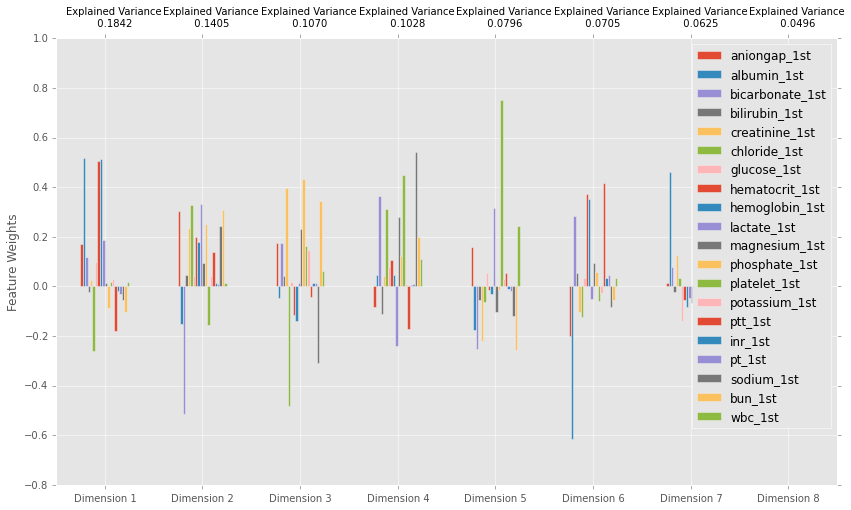

In [428]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca_norm = PCA(n_components = 8).fit(good_norm_data[good_norm_data.columns[1:]])

# Generate PCA results plot
pca_norm_results = vs.pca_results(good_norm_data[good_norm_data.columns[1:]], pca_norm)

## Code to identify outliers in Box-Cox transformed data

In [421]:
names_dict = {}
suffix = '_outliers'


for feature in boxcox_norm_data.keys():
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_norm_data[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_norm_data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_norm_data[~((boxcox_norm_data[feature] >= Q1 - step) & (boxcox_norm_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

## Code to remove datapoints from Box-Cox transformed data with 3 or more variables that are outliers

In [422]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts > 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


good_boxcox_norm_data = boxcox_norm_data.drop(boxcox_norm_data.index[outliers]).reset_index(drop = True)

the total outlier indices = 150
the following data points have >2 outlying feature and will be removed: 
[205, 340, 407, 465, 516, 547, 631, 672, 681]


## Scatterplot of Box-Cox transformed data with outliers removed. 

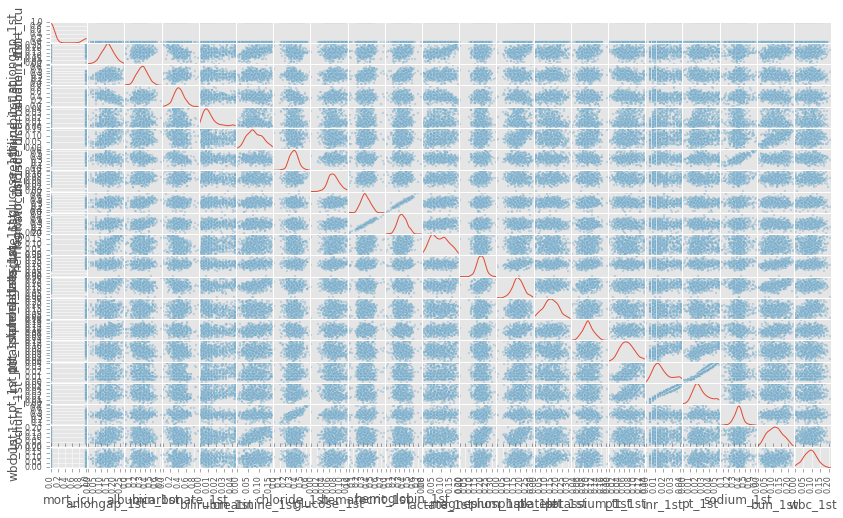

In [423]:
pd.scatter_matrix(good_boxcox_norm_data[1:], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## PCA performed on Box-Cox transformed data with outliers removed. 

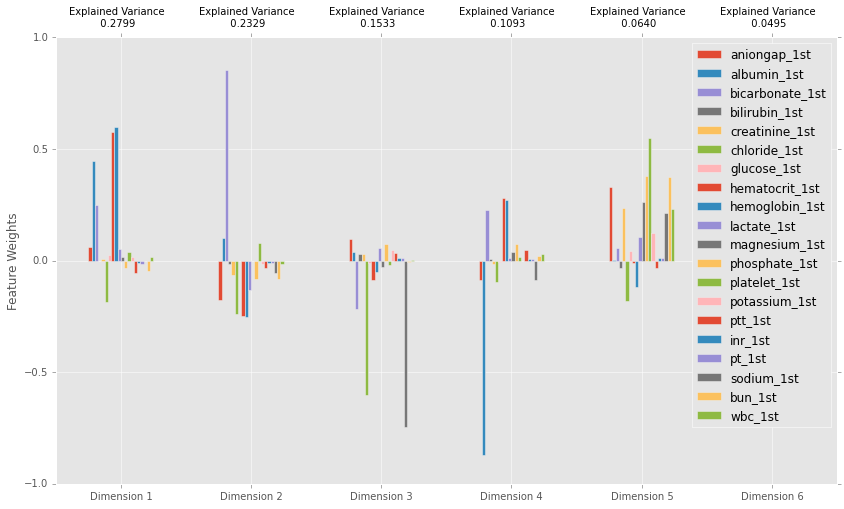

In [426]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca_boxcox = PCA(n_components = 6).fit(good_boxcox_norm_data[good_boxcox_norm_data.columns[1:]])

# Generate PCA results plot
pca_boxcox_results = vs.pca_results(good_boxcox_norm_data[good_boxcox_norm_data.columns[1:]], pca_boxcox)

## Normalized data with outliers removed transformed using PCA . Data dimensionality reduced from 21 to 8. 

In [429]:
reduced_norm_data = pca_norm.transform(good_norm_data[good_norm_data.columns[1:]])
reduced_norm_data = pd.DataFrame(reduced_norm_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 
                                                    'Dimension 5', 'Dimension 6', 'Dimension 7', 'Dimension 8'])
reduced_norm_data.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8
0,-0.165666,0.003226,0.205217,0.029736,0.029728,0.020811,-0.057307,0.020000
1,0.064445,0.021406,-0.012561,-0.173331,0.102648,-0.013831,-0.019588,-0.060284
2,0.091092,0.034413,0.376188,0.025411,-0.190027,0.011358,-0.057697,0.214891
3,-0.224761,0.332333,-0.365819,0.442484,-0.282059,-0.166149,-0.019493,0.072600
4,0.398618,-0.014333,-0.147811,0.100851,0.003257,0.065767,0.009837,0.061526


In [430]:
good_boxcox_norm_data.columns

Index([u'mort_icu', u'aniongap_1st', u'albumin_1st', u'bicarbonate_1st',
       u'bilirubin_1st', u'creatinine_1st', u'chloride_1st', u'glucose_1st',
       u'hematocrit_1st', u'hemoglobin_1st', u'lactate_1st', u'magnesium_1st',
       u'phosphate_1st', u'platelet_1st', u'potassium_1st', u'ptt_1st',
       u'inr_1st', u'pt_1st', u'sodium_1st', u'bun_1st', u'wbc_1st'],
      dtype='object')

## Box-Cox transformed data with outliers removed transformed using PCA. Reduced from 21 to 6 dimensions. 

In [432]:
reduced_boxcox_norm_data = pca_boxcox.transform(good_boxcox_norm_data[good_boxcox_norm_data.columns[1:]])
reduced_boxcox_norm_data = pd.DataFrame(reduced_boxcox_norm_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 
                                                    'Dimension 5', 'Dimension 6'])
reduced_boxcox_norm_data.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-0.122816,0.056963,0.029210,0.079527,0.076029,0.001194
1,0.034159,-0.098746,0.091823,-0.003410,-0.031969,0.058336
2,0.066759,0.172703,0.039860,0.083862,0.077260,-0.118214
3,-0.100017,-0.096364,-0.398040,-0.094055,-0.006400,-0.083740
4,0.307866,0.029200,-0.101004,0.002516,-0.018902,0.016875


## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [504]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(reduced_norm_data, 
                                                    good_norm_data['mort_icu'], test_size = 0.20, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


0.822033898305


array([[95,  4],
       [17,  2]])

## Box-Cox transformed data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [505]:
X_train, X_test, y_train, y_test = train_test_split(reduced_boxcox_norm_data, 
                                                    good_boxcox_norm_data['mort_icu'], test_size = 0.20, random_state = 42)


### create classifier
clf_GNB2 = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB2.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB2.score(X_test, y_test) 

print nb_score
y_predsGNB2 = clf_GNB2.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB2)



0.808823529412


array([[107,   3],
       [ 23,   3]])

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [489]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(reduced_norm_data, good_norm_data['mort_icu'], test_size = 0.15, random_state = 42)


clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

clf.score(X_test, y_test)

0.8314606741573034

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [523]:

X_train, X_test, y_train, y_test = train_test_split(reduced_boxcox_norm_data, 
                                                    good_boxcox_norm_data['mort_icu'], test_size = 0.40, 
                                                    random_state = 42)


clf = MLPClassifier(solver= 'lbfgs', alpha=1e-5,max_iter = 300, activation = 'relu',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

print clf.score(X_test, y_test)
y_preds = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_preds)

0.827205882353


array([[211,   7],
       [ 40,  14]])

In [524]:
y_preds

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0

In [525]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [536]:
data3 = data.dropna()
data3.head()

,subject_id,hadm_id,icustay_id,mort_icu,mort_hosp,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,21,111970,216859,1,1,19.0,2.1,23.0,0.3,4.2,...,1.5,4.4,275.0,3.8,31.7,1.7,18.1,137.0,49.0,30.5
4,188,191517,278679,0,0,14.0,2.9,17.0,1.8,2.4,...,1.0,3.3,266.0,5.0,32.7,1.2,13.7,133.0,31.0,16.7
5,353,108923,224409,0,0,22.0,2.6,30.0,0.3,7.6,...,2.0,3.0,165.0,5.1,24.9,1.3,14.2,138.0,66.0,13.1
7,357,122609,273842,0,0,17.0,2.9,20.0,0.2,1.9,...,2.3,2.6,109.0,3.1,29.8,1.4,15.9,166.0,77.0,5.0
8,366,134462,255905,0,0,18.0,3.7,27.0,0.8,1.5,...,1.7,2.3,217.0,5.3,28.6,1.2,13.4,143.0,17.0,30.6


In [ ]:
clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='poly', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scores = cross_val_score(clf_SVC, data3[data3.columns[5:]], data3['mort_icu'], cv=5)
display(scores)                   

'''
X_train, X_test, y_train, y_test = train_test_split(good_norm_data, good_norm_data['mort_icu'], 
                                                    test_size = 0.40, random_state = 42)



clf_SVC.fit(X_train, y_train)                         

y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))
'''

In [ ]:
data[data.columns[5:]].head()

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [439]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(reduced_norm_data, good_norm_data['mort_icu'], test_size = 0.15, random_state = 42)


clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

clf.score(X_test, y_test)

0.8202247191011236

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
print "monkey"